In [2]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-05-15
# For ICROS2023
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime

from Function.ReceptiveField import *
from Function.SNNModule import *
from Function.plot_SNN import *
from Function.SNN import *
from Function.Stimulation_GPU import *

from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

GPU available: True
CUDA version: 10.1
Using device: cpu


In [4]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [5]:
#1st layer
############################################################################################################################################################
# Generate Slowly Adapting (SA) and Rapidly Adapting (RA) receptive fields
scale_factor = 5 if pixel_h == 320 else 1

SA_RF, [SA_rf_height, SA_rf_width] = generate_mechanoreceptor_to_afferent_rf(pixel_h = pixel_h, pixel_w = pixel_w, kernel_w=9*scale_factor, kernel_h=11*scale_factor, step_size=5*scale_factor, device=device)
RA_RF, [RA_rf_height, RA_rf_width] = generate_mechanoreceptor_to_afferent_rf(pixel_h = pixel_h, pixel_w = pixel_w, kernel_w=11*scale_factor, kernel_h=14*scale_factor, step_size=4*scale_factor, device=device)

print(SA_RF.shape)
# Print the shape of the SA_rf variable
print("SA_rf shape:", SA_RF.shape, 'with height =',SA_rf_height, 'with width =', SA_rf_width)
print("RA_rf shape:", RA_RF.shape, 'with height =',RA_rf_height, 'with width =', RA_rf_width)
############################################################################################################################################################

#2nd layer
############################################################################################################################################################
# Define optimized receptive fields and synaptic delays
CN_PN_RF = [torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]],device=device) * 4]
CN_IN_RF = [torch.tensor([[1, 1, 1], [1, 0, 1], [1, 1, 1]],device=device)]
CN_SD = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]

CN_INtoPN_RF = []

# Check if the sizes of the inner tensors are different and print the index
for i, (PN, IN) in enumerate(zip(CN_PN_RF, CN_IN_RF)):
    if PN.size() != IN.size():
        raise ValueError(
            f"The inner tensors at index {i} have different sizes: {PN.size()} != {IN.size()}")

SA_CN_PN_RF, [SA_CN_PN_step_height, SA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
SA_CN_IN_RF, [SA_CN_IN_step_height, SA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
SA_CN_SD, [SA_CN_SD_step_height, SA_CN_SD_step_width]  = generate_weight(CN_SD, pixel_h=SA_rf_height,pixel_w=SA_rf_width, step_size=1, device=device)
RA_CN_PN_RF, [RA_CN_PN_step_height, RA_CN_PN_step_width] = generate_weight(CN_PN_RF, pixel_h=RA_rf_height,pixel_w=RA_rf_width, step_size=1, device=device)
RA_CN_IN_RF, [RA_CN_IN_step_height, RA_CN_IN_step_width] = generate_weight(CN_IN_RF, pixel_h=RA_rf_height,pixel_w=RA_rf_width, step_size=1, device=device)
RA_CN_SD, [RA_CN_SD_step_height, RA_CN_SD_step_width] = generate_weight(CN_SD, pixel_h=RA_rf_height, pixel_w=RA_rf_width, step_size=1, device=device)

SA_INtoPN_RF, SA_INtoPN_DN = create_weight_matrix(len(SA_CN_IN_RF), len(SA_CN_PN_RF), connection_probability=0.2, device=device)
RA_INtoPN_RF, RA_INtoPN_DN = create_weight_matrix(len(RA_CN_IN_RF), len(RA_CN_PN_RF), connection_probability=0.2, device=device)

print("SA_CN_PN_RF shape: ", SA_CN_PN_RF.shape,"SA_CN_PN_step_height:", SA_CN_PN_step_height,"SA_CN_PN_step_width:", SA_CN_PN_step_width)
print("SA_CN_IN_RF shape: ", SA_CN_IN_RF.shape,"SA_CN_IN_step_height:", SA_CN_IN_step_height,"SA_CN_IN_step_width:", SA_CN_IN_step_width)
print("RA_CN_PN_RF shape: ", RA_CN_PN_RF.shape,"RA_CN_PN_step_height:", RA_CN_PN_step_height,"RA_CN_PN_step_width:", RA_CN_PN_step_width)
print("RA_CN_IN_RF shape: ", RA_CN_IN_RF.shape,"RA_CN_IN_step_height:", RA_CN_IN_step_height,"RA_CN_IN_step_width:", RA_CN_IN_step_width)
print("SA_INtoPN_RF shape: ", SA_INtoPN_RF.shape)
print("RA_INtoPN_RF shape: ", RA_INtoPN_RF.shape)
############################################################################################################################################################

#3rd layer
############################################################################################################################################################
# 3rd integration layer
# Define optimized receptive fields and synaptic delays
CN_PN_RF_set = [torch.tensor([[0, 0, 0], [0, 0, 0], [1, 1 ,1]], device=device),torch.tensor([[0, 0, 1], [0, 1, 0], [1, 0, 0]], device=device),torch.tensor([[0, 0, 1], [0, 0, 1], [0, 0 ,1]], device=device),
                torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], device=device)]
CN_IN_RF_set = [torch.tensor([[0, 0, 0], [1, 1 ,1], [0, 0 ,0]], device=device),torch.tensor([[0, 1, 0], [1, 0, 0], [0, 0, 0]], device=device)*3/2,torch.tensor([[0, 1, 0], [0, 1 ,0], [0, 1 ,0]], device=device),
                torch.tensor([[0, 1, 0], [0, 0, 1], [0, 0, 0]], device=device)*3/2]
CN_SD_set = [torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),
             torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device),torch.tensor([[2, 2, 2], [2, 2, 2], [2, 2, 2]], device=device)]
rf_sizes=[(7, 4)]

CN_PN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0],[0, 0, 0, 0, 0],[1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1]], device=device)/10*3,
                   torch.tensor([[0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0]], device=device)/5*3,
                   torch.tensor([[0, 0, 0, 1, 1], [0, 0, 0, 1, 1],[0, 0, 0, 1, 1],[0, 0, 0 ,1, 1], [0, 0, 0 ,1, 1]], device=device)/10*3,
                   torch.tensor([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]], device=device)/5*3]

CN_IN_RF_RA_set = [torch.tensor([[0, 0, 0, 0, 0], [1, 1, 1 ,1, 1], [1, 1, 1 ,1, 1], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], device=device)/10*3,
                   torch.tensor([[0, 0, 0, 1, 0], [0, 0, 1, 0, 0], [0, 1, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]], device=device)/5*3,
                   torch.tensor([[0, 1, 1, 0, 0], [0, 1, 1, 0, 0],[0, 1, 1, 0, 0],[0, 1, 1, 0, 0], [0, 1, 1, 0, 0]], device=device)/10*3,
                   torch.tensor([[0, 1, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]], device=device)/5*3,
                   ]

CN_SD__RA_set = [torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device),
                 torch.tensor([[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2],[2, 2, 2 ,2, 2]], device=device)]


# CN_PN_RF, CN_PN_DN = create_weight_matrix(len(SA_CN_PN_RF)+len(RA_CN_PN_RF),num_output_neuron,connection_probability = 0.2, device = device)
CN_PN_SA_RF, [CN_PN_SA_RF_step_height, CN_PN_SA_RF_step_width] = generate_weight(CN_PN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_IN_SA_RF, [CN_IN_SA_RF_step_height, CN_IN_SA_RF_step_width] = generate_weight(CN_IN_RF_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)
CN_SA_SD, [CN_SA_SD_step_height, CN_SA_SD_step_width] = generate_weight(
    CN_SD_set, pixel_h=SA_CN_PN_step_height, pixel_w=SA_CN_PN_step_width, step_size=1, device=device)

CN_PN_RA_RF, [CN_PN_RA_RF_step_height, CN_PN_RA_RF_step_width] = generate_weight(CN_PN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_IN_RA_RF, [CN_IN_RA_RF_step_height, CN_IN_RA_RF_step_width] = generate_weight(CN_IN_RF_RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)
CN_RA_SD, [CN_RA_SD_step_height, CN_RA_SD_step_width] = generate_weight(
    CN_SD__RA_set, pixel_h=RA_CN_PN_step_height, pixel_w=RA_CN_PN_step_width, step_size=1, device=device)

CN_INtoPN_RF, CN_INtoPN_DN = create_weight_matrix(len(CN_IN_SA_RF), len(CN_PN_SA_RF), connection_probability=0.2, device=device)

print("CN_PN_SA_RF shape: ", CN_PN_SA_RF.shape, "CN_PN_SA_RF_step_height:", CN_PN_SA_RF_step_height, "CN_PN_SA_RF_step_width:", CN_PN_SA_RF_step_width)
print("CN_IN_SA_RF shape: ", CN_IN_SA_RF.shape, "CN_IN_SA_RF_step_height:", CN_IN_SA_RF_step_height, "CN_IN_SA_RF_step_width:", CN_IN_SA_RF_step_width)
print("CN_PN_RA_RF shape: ", CN_PN_RA_RF.shape, "CN_PN_RA_RF_step_height:", CN_PN_RA_RF_step_height, "CN_PN_RA_RF_step_width:", CN_PN_RA_RF_step_width)
print("CN_IN_RA_RF shape: ", CN_IN_RA_RF.shape, "CN_IN_RA_RF_step_height:", CN_IN_RA_RF_step_height, "CN_IN_RA_RF_step_width:", CN_IN_RA_RF_step_width)
print("CN_INtoPN_RF shape: ", CN_INtoPN_RF.shape)
############################################################################################################################################################

torch.Size([88, 3072])
SA_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
RA_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
SA_CN_PN_RF shape:  torch.Size([54, 88]) SA_CN_PN_step_height: 9 SA_CN_PN_step_width: 6
SA_CN_IN_RF shape:  torch.Size([54, 88]) SA_CN_IN_step_height: 9 SA_CN_IN_step_width: 6
RA_CN_PN_RF shape:  torch.Size([88, 130]) RA_CN_PN_step_height: 11 RA_CN_PN_step_width: 8
RA_CN_IN_RF shape:  torch.Size([88, 130]) RA_CN_IN_step_height: 11 RA_CN_IN_step_width: 8
SA_INtoPN_RF shape:  torch.Size([54, 54])
RA_INtoPN_RF shape:  torch.Size([88, 88])
CN_PN_SA_RF shape:  torch.Size([112, 54]) CN_PN_SA_RF_step_height: 7 CN_PN_SA_RF_step_width: 4
CN_IN_SA_RF shape:  torch.Size([112, 54]) CN_IN_SA_RF_step_height: 7 CN_IN_SA_RF_step_width: 4
CN_PN_RA_RF shape:  torch.Size([112, 88]) CN_PN_RA_RF_step_height: 7 CN_PN_RA_RF_step_width: 4
CN_IN_RA_RF shape:  torch.Size([112, 88]) CN_IN_RA_RF_step_height: 7 CN_IN_RA_RF_step_width: 4
CN_INtoPN_RF shape:

In [6]:
noise_std_val = 10

# Create Izhikevich layers
SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.01, noise_std = noise_std_val, device=device)
SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
SA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
RA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

SA_synapse = Synapse(SA_RF.to(device), device=device)
SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

RA_synapse = Synapse(RA_RF.to(device), device=device)
RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
RA_synapses = [RA_synapse, RA_CN_IN_synapse, RA_CN_PN_synapse, RA_CN_INtoPN_synapse]

# 3rd layer 
CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

CN_layers = [CN_IN_layer, CN_PN_layer]
CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]

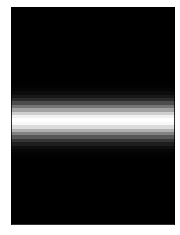

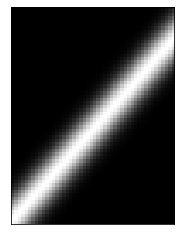

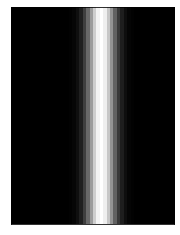

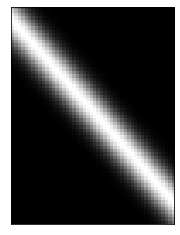

cpu
torch.Size([64, 48, 1000])


In [7]:
num_stim = 1000

# Generate the stimuli and stack them up
F = 10
stimulation_angle_0_notmoving = generate_stimuli(0, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device = device)
stimulation_angle_45_notmoving = generate_stimuli(45, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device = device)
stimulation_angle_90_notmoving = generate_stimuli(90, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device = device)
stimulation_angle_135_notmoving = generate_stimuli(135, num_stim, pixel_h, pixel_w, F=F, plot_stimuli=True, device = device)
print(stimulation_angle_90_notmoving.device)
print(stimulation_angle_0_notmoving.shape)

start feedforward with stimulation_angle_0_notmoving


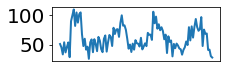

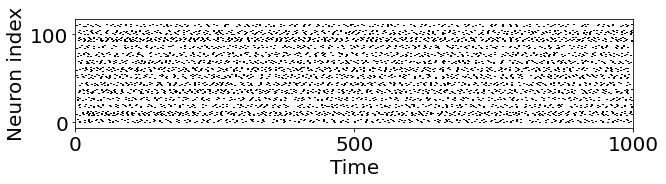

start feedforward with stimulation_angle_45_notmoving


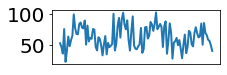

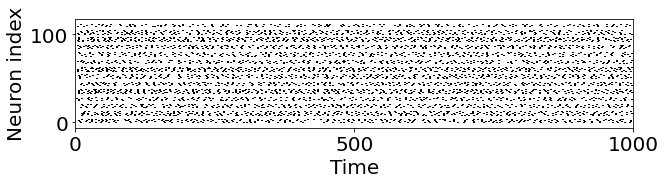

start feedforward with stimulation_angle_90_notmoving


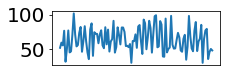

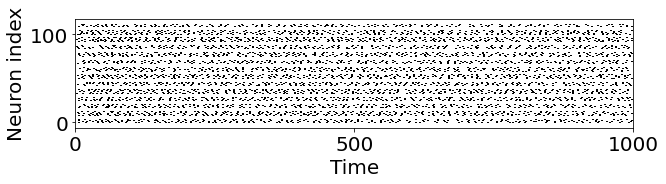

start feedforward with stimulation_angle_135_notmoving


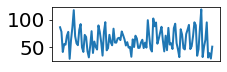

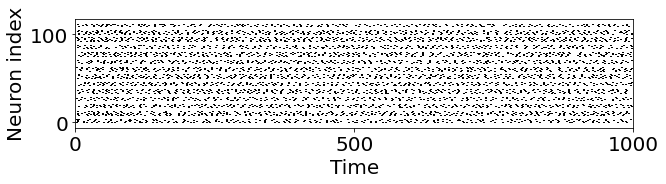

In [8]:
angles = [0, 45, 90, 135]  # define angles
for angle in angles:
    S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

    # assuming 'stimulation_angle_x_notmoving' is an input corresponding to angle x
    stim_name = f'stimulation_angle_{angle}_notmoving'
    stimulation = globals()[stim_name]

    S.feedforward(stimulation, stim_name)
    mean_firing_rates = plot_SNN(S)

    plt.rcParams['font.size'] = 20
    fig_size = (10, 2)
    line_lengths = 0.6
    plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='k', line_lengths=line_lengths)


# print(datetime.datetime.now())


start feedforward with stimulation_angle_0_notmoving


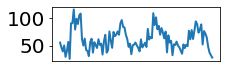

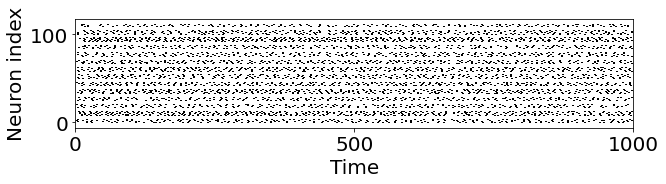

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees. 

start feedforward with stimulation_angle_45_notmoving


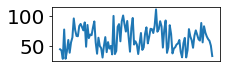

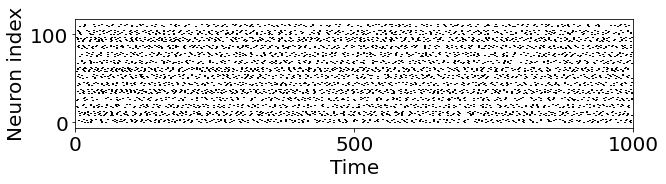

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees. 

start feedforward with stimulation_angle_90_notmoving


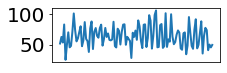

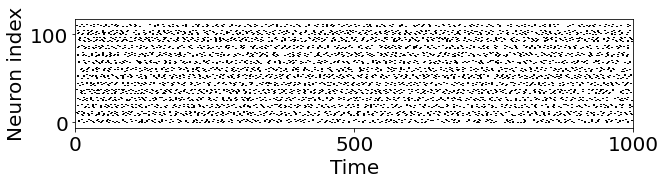

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees. 

start feedforward with stimulation_angle_135_notmoving


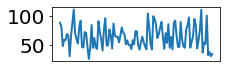

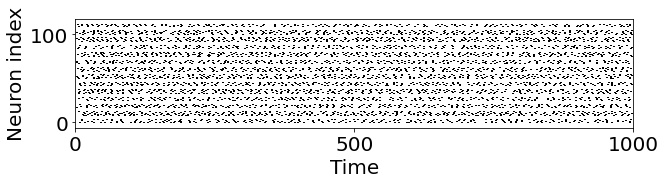

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees. 



In [9]:
angles = [0, 45, 90, 135]  # define angles
angle_classes = [range(0, 28), range(28, 56), range(56, 84), range(84, 112)]  # define classes by index ranges

for angle in angles:
    S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

    # assuming 'stimulation_angle_x_notmoving' is an input corresponding to angle x
    stim_name = f'stimulation_angle_{angle}_notmoving'
    stimulation = globals()[stim_name]

    S.feedforward(stimulation, stim_name)
    mean_firing_rates = plot_SNN(S)

    plt.rcParams['font.size'] = 20
    fig_size = (10, 2)
    line_lengths = 0.6
    plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='k', line_lengths=line_lengths)
    
    # find the index of the maximum mean firing rate
    max_rate_index = torch.argmax(mean_firing_rates)

    # determine the class of the maximum mean firing rate
    for i, class_range in enumerate(angle_classes):
        if max_rate_index in class_range:
            print(f"For the stimulation with angle {angle} degrees, the class with the highest mean firing rate is {angles[i]} degrees. \n")
            break

start feedforward with stimulation_angle_0_notmoving


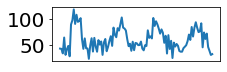

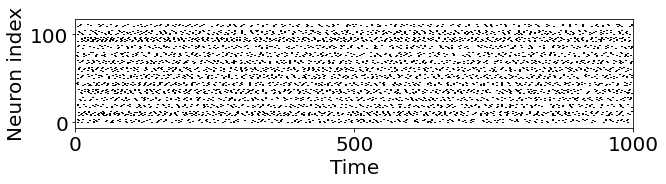

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


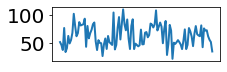

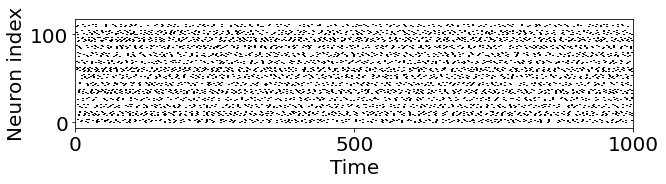

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


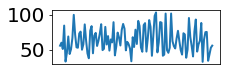

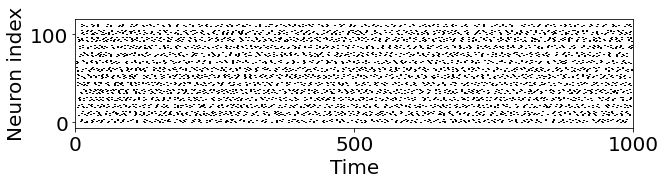

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


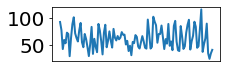

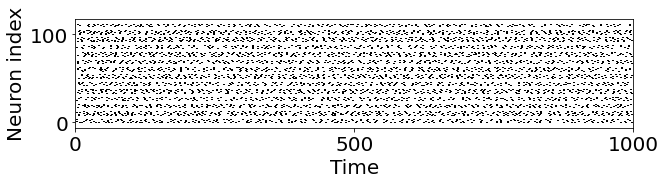

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model is 100.0%.


In [10]:
angles = [0, 45, 90, 135]  # define angles
angle_classes = [range(0, 28), range(28, 56), range(56, 84), range(84, 112)]  # define classes by index ranges
correct_count = 0  # initialize the count of correct predictions

for angle in angles:
    S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

    # assuming 'stimulation_angle_x_notmoving' is an input corresponding to angle x
    stim_name = f'stimulation_angle_{angle}_notmoving'
    stimulation = globals()[stim_name]

    S.feedforward(stimulation, stim_name)
    mean_firing_rates = plot_SNN(S)

    plt.rcParams['font.size'] = 20
    fig_size = (10, 2)
    line_lengths = 0.6
    plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='k', line_lengths=line_lengths)

    # find the index of the maximum mean firing rate
    max_rate_index = torch.argmax(mean_firing_rates)

    # determine the class of the maximum mean firing rate
    for i, class_range in enumerate(angle_classes):
        if max_rate_index in class_range:
            predicted_angle = angles[i]
            print(f"For the stimulation with angle {angle} degrees, the class with the highest mean firing rate is {predicted_angle} degrees.")
            if angle == predicted_angle:
                correct_count += 1
            break

accuracy = correct_count / len(angles) * 100  # calculate accuracy
print(f"\nThe accuracy of the model is {accuracy}%.")

Starting iteration 1...
start feedforward with stimulation_angle_0_notmoving


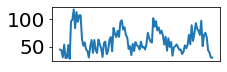

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


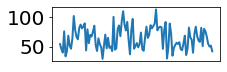

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


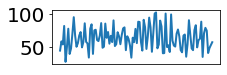

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


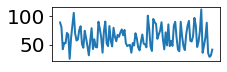

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 1 is 75.0%.

Starting iteration 2...
start feedforward with stimulation_angle_0_notmoving


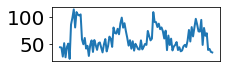

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


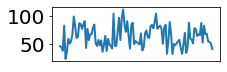

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


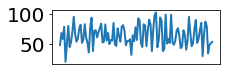

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


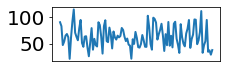

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 2 is 75.0%.

Starting iteration 3...
start feedforward with stimulation_angle_0_notmoving


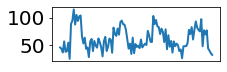

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


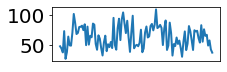

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


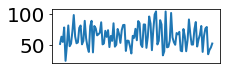

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


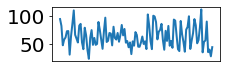

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 3 is 75.0%.

Starting iteration 4...
start feedforward with stimulation_angle_0_notmoving


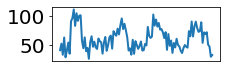

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


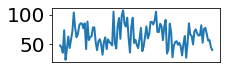

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


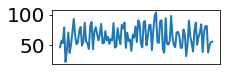

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


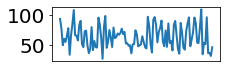

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 4 is 100.0%.

Starting iteration 5...
start feedforward with stimulation_angle_0_notmoving


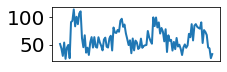

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


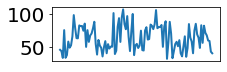

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


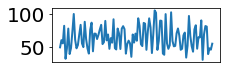

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


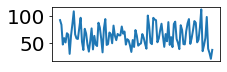

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 5 is 100.0%.

Starting iteration 6...
start feedforward with stimulation_angle_0_notmoving


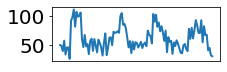

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


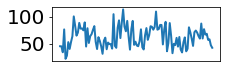

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


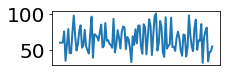

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


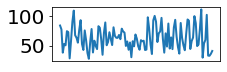

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 6 is 100.0%.

Starting iteration 7...
start feedforward with stimulation_angle_0_notmoving


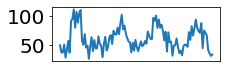

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


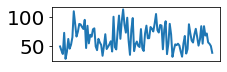

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


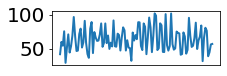

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


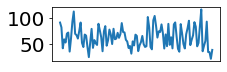

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 7 is 100.0%.

Starting iteration 8...
start feedforward with stimulation_angle_0_notmoving


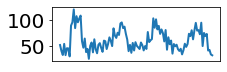

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


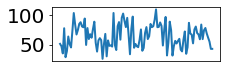

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


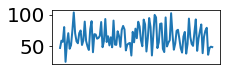

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_135_notmoving


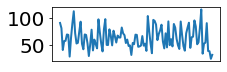

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 8 is 50.0%.

Starting iteration 9...
start feedforward with stimulation_angle_0_notmoving


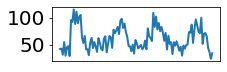

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


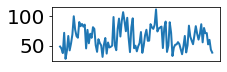

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


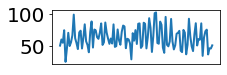

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


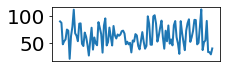

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 9 is 75.0%.

Starting iteration 10...
start feedforward with stimulation_angle_0_notmoving


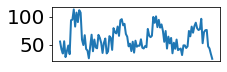

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


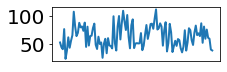

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


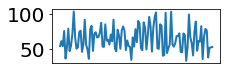

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_135_notmoving


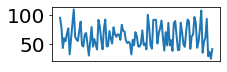

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 10 is 25.0%.

Starting iteration 11...
start feedforward with stimulation_angle_0_notmoving


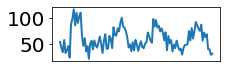

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


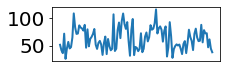

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


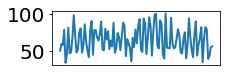

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


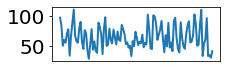

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 11 is 50.0%.

Starting iteration 12...
start feedforward with stimulation_angle_0_notmoving


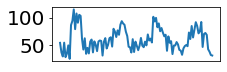

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


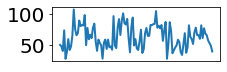

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_90_notmoving


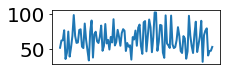

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


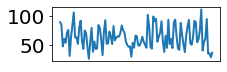

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 12 is 75.0%.

Starting iteration 13...
start feedforward with stimulation_angle_0_notmoving


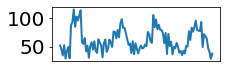

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


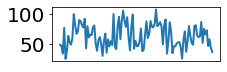

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


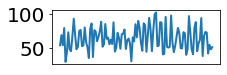

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


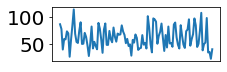

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 13 is 50.0%.

Starting iteration 14...
start feedforward with stimulation_angle_0_notmoving


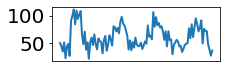

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


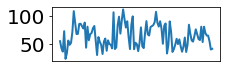

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


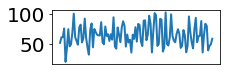

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


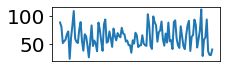

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 14 is 100.0%.

Starting iteration 15...
start feedforward with stimulation_angle_0_notmoving


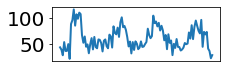

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


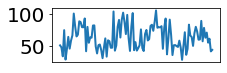

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


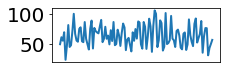

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


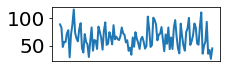

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 15 is 50.0%.

Starting iteration 16...
start feedforward with stimulation_angle_0_notmoving


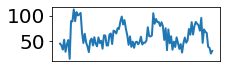

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


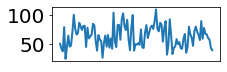

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


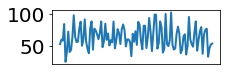

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


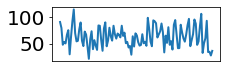

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 16 is 50.0%.

Starting iteration 17...
start feedforward with stimulation_angle_0_notmoving


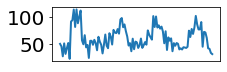

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


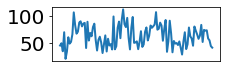

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


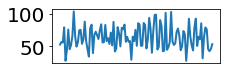

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_135_notmoving


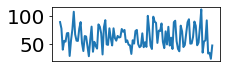

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 17 is 75.0%.

Starting iteration 18...
start feedforward with stimulation_angle_0_notmoving


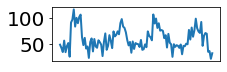

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


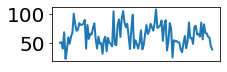

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


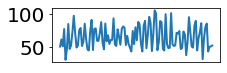

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


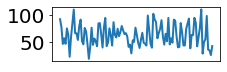

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 135 degrees.

The accuracy of the model for iteration 18 is 75.0%.

Starting iteration 19...
start feedforward with stimulation_angle_0_notmoving


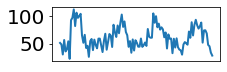

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


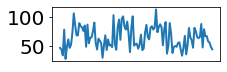

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_90_notmoving


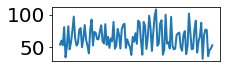

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


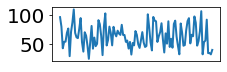

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 19 is 50.0%.

Starting iteration 20...
start feedforward with stimulation_angle_0_notmoving


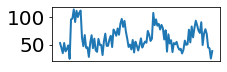

For the stimulation with angle 0 degrees, the class with the highest mean firing rate is 0 degrees.
start feedforward with stimulation_angle_45_notmoving


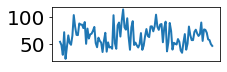

For the stimulation with angle 45 degrees, the class with the highest mean firing rate is 45 degrees.
start feedforward with stimulation_angle_90_notmoving


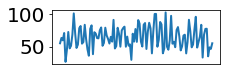

For the stimulation with angle 90 degrees, the class with the highest mean firing rate is 90 degrees.
start feedforward with stimulation_angle_135_notmoving


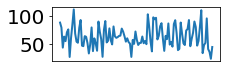

For the stimulation with angle 135 degrees, the class with the highest mean firing rate is 0 degrees.

The accuracy of the model for iteration 20 is 75.0%.


The mean accuracy of the model over 20 iterations is 71.25%.


In [11]:
num_iterations = 20  # define the number of iterations
angles = [0, 45, 90, 135]  # define angles
angle_classes = [range(0, 28), range(28, 56), range(56, 84), range(84, 112)]  # define classes by index ranges

accuracies = []  # list to store accuracies for each iteration

for iteration in range(num_iterations):

    print(f"Starting iteration {iteration + 1}...")

    correct_count = 0  # initialize the count of correct predictions

    for angle in angles:
        S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)

        # assuming 'stimulation_angle_x_notmoving' is an input corresponding to angle x
        stim_name = f'stimulation_angle_{angle}_notmoving'
        stimulation = globals()[stim_name]

        S.feedforward(stimulation, stim_name)
        mean_firing_rates = plot_SNN(S)

        plt.rcParams['font.size'] = 20
        fig_size = (10, 2)
        line_lengths = 0.6
        # plot_spike_times(S.CN_spike_times[0], size=fig_size, colors='k', line_lengths=line_lengths)

        # find the index of the maximum mean firing rate
        max_rate_index = torch.argmax(mean_firing_rates)

        # determine the class of the maximum mean firing rate
        for i, class_range in enumerate(angle_classes):
            if max_rate_index in class_range:
                predicted_angle = angles[i]
                print(f"For the stimulation with angle {angle} degrees, the class with the highest mean firing rate is {predicted_angle} degrees.")
                if angle == predicted_angle:
                    correct_count += 1
                break

    accuracy = correct_count / len(angles) * 100  # calculate accuracy for the current iteration
    accuracies.append(accuracy)  # add to the list of accuracies

    print(f"\nThe accuracy of the model for iteration {iteration + 1} is {accuracy}%.\n")

mean_accuracy = sum(accuracies) / len(accuracies)  # calculate the mean accuracy over all iterations
print(f"\nThe mean accuracy of the model over {num_iterations} iterations is {mean_accuracy}%.")


0.0
start feedforward with stimulation_angle_0_notmoving
start feedforward with stimulation_angle_45_notmoving
start feedforward with stimulation_angle_90_notmoving
start feedforward with stimulation_angle_135_notmoving
start feedforward with stimulation_angle_0_notmoving
start feedforward with stimulation_angle_45_notmoving
start feedforward with stimulation_angle_90_notmoving
start feedforward with stimulation_angle_135_notmoving
start feedforward with stimulation_angle_0_notmoving
start feedforward with stimulation_angle_45_notmoving
start feedforward with stimulation_angle_90_notmoving
start feedforward with stimulation_angle_135_notmoving
start feedforward with stimulation_angle_0_notmoving
start feedforward with stimulation_angle_45_notmoving
start feedforward with stimulation_angle_90_notmoving
start feedforward with stimulation_angle_135_notmoving
start feedforward with stimulation_angle_0_notmoving
start feedforward with stimulation_angle_45_notmoving
start feedforward with st

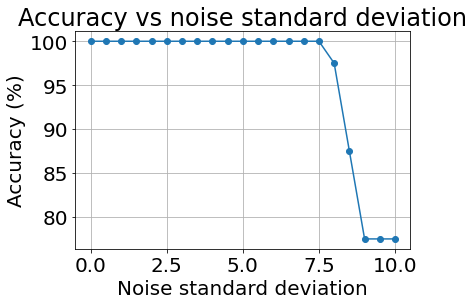

In [18]:
# Define parameters
noise_stds = np.linspace(0, 10, 21)  # Noise standard deviation values
num_repeats = 10  # Number of repetitions per noise_std

# Store the accuracies for each noise_std
accuracies = []

# Loop over noise_std values
for noise_std_val in noise_stds:
    print(noise_std_val) # Print
    correct_count = 0  # Initialize the count of correct predictions
    # Create Izhikevich layers
    SA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(SA_RF),v_thres=30, a_decay=1.01, noise_std = noise_std_val, device=device)
    SA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_IN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
    SA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(SA_CN_PN_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

    RA_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(RA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
    RA_CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_IN_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
    RA_CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(RA_CN_PN_RF),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

    SA_layers = [SA_layer, SA_CN_IN_layer, SA_CN_PN_layer]
    RA_layers = [RA_layer, RA_CN_IN_layer, RA_CN_PN_layer]

    SA_synapse = Synapse(SA_RF.to(device), device=device)
    SA_CN_IN_synapse = Synapse(SA_CN_IN_RF.to(device), delays=SA_CN_SD, device=device)
    SA_CN_PN_synapse = Synapse(SA_CN_PN_RF.to(device), delays=SA_CN_SD, device=device)
    SA_CN_INtoPN_synapse = Synapse(SA_INtoPN_RF.to(device), delays = SA_INtoPN_DN, tau_psp = 10, device = device)

    RA_synapse = Synapse(RA_RF.to(device), device=device)
    RA_CN_IN_synapse = Synapse(RA_CN_IN_RF.to(device), delays=RA_CN_SD, device=device)
    RA_CN_PN_synapse = Synapse(RA_CN_PN_RF.to(device), delays=RA_CN_SD, device=device)
    RA_CN_INtoPN_synapse = Synapse(RA_INtoPN_RF.to(device), delays = RA_INtoPN_DN, tau_psp = 10, device = device)

    SA_synapses = [SA_synapse, SA_CN_IN_synapse, SA_CN_PN_synapse, SA_CN_INtoPN_synapse]
    RA_synapses = [RA_synapse, RA_CN_IN_synapse, RA_CN_PN_synapse, RA_CN_INtoPN_synapse]

    # 3rd layer 
    CN_IN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_IN_SA_RF), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
    CN_PN_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(CN_PN_SA_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

    CN_IN_SA_synapse = Synapse(CN_IN_SA_RF.to(device), delays=CN_SA_SD, device=device)
    CN_PN_SA_synapse = Synapse(CN_PN_SA_RF.to(device), delays=CN_SA_SD, device=device)
    CN_IN_RA_synapse = Synapse(CN_IN_RA_RF.to(device), delays=CN_RA_SD, device=device)
    CN_PN_RA_synapse = Synapse(CN_PN_RA_RF.to(device), delays=CN_RA_SD, device=device)

    CN_INtoPN_synapse = Synapse(CN_INtoPN_RF.to(device), delays = CN_INtoPN_DN, tau_psp = 10, device = device)

    CN_layers = [CN_IN_layer, CN_PN_layer]
    CN_synapses = [CN_IN_SA_synapse, CN_PN_SA_synapse, CN_IN_RA_synapse, CN_PN_RA_synapse, CN_INtoPN_synapse]
    # Repeat the experiment num_repeats times
    for _ in range(num_repeats):
        for angle in angles:
            S = SNNModel([SA_layers, RA_layers, CN_layers], 
                         [SA_synapses, RA_synapses, CN_synapses], 
                         rf_sizes=rf_sizes, device=device)

            stim_name = f'stimulation_angle_{angle}_notmoving'
            stimulation = globals()[stim_name]

            S.feedforward(stimulation, stim_name)
            
            mean_firing_rates = plot_SNN(S,plot_figure = False)

            max_rate_index = torch.argmax(mean_firing_rates)

            for i, class_range in enumerate(angle_classes):
                if max_rate_index in class_range:
                    predicted_angle = angles[i]
                    if angle == predicted_angle:
                        correct_count += 1
                    break

    # Calculate and store the accuracy for this noise_std
    accuracy = correct_count / (len(angles) * num_repeats) * 100
    accuracies.append(accuracy)

# Plot the results
plt.plot(noise_stds, accuracies, 'o-')
plt.xlabel('Noise standard deviation')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs noise standard deviation')
plt.grid(True)
plt.show()